In [70]:
# -*- coding: utf-8 -*-
# Author: JoeBuzh

import os
import sys
from datetime import datetime, timedelta

import xlrd
import xlwt
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# tf & keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [71]:
tf.__version__, pd.__version__, keras.__version__

('1.15.0', '1.0.3', '2.2.4-tf')

In [4]:
# HyperParams
BATCH = 32
SEQ_IN = 42
SEQ_OUT = 42
INDEX = 'TN'
# MODE = 'LSTM'
# EPOCH = 1000

In [5]:
data_dir = '../output'
train_file = '洛宁长水4h验证原始数据-线性扩展.xls'
valid_file = '大乌江4h验证原始数据-线性扩展.xls'
test_file = '沿江渡4h验证原始数据-线性扩展.xls'

In [6]:
def read_data(filepath):
    assert os.path.exists(filepath)
    data = pd.read_excel(filepath, 
        names=['Time', 'Temp', 'pH', 'DO', 'Elecon', 'Turbidity', 'CODMn', 'NH3N', 'TP', 'TN'],
        encoding='utf-8')
    return data

+ Read Raw Data

In [7]:
train_data = read_data(os.path.join(data_dir, train_file))
valid_data = read_data(os.path.join(data_dir, valid_file))
test_data = read_data(os.path.join(data_dir, test_file))

+ 时间完备性检查

In [8]:
train_data.shape, valid_data.shape, test_data.shape

((3889, 10), (472, 10), (472, 10))

In [9]:
pd.date_range('2018-11-1 00', '2020-8-10 00', freq='4h').shape[0] # 时间序列完备

3889

In [10]:
pd.date_range('2020-5-26 00', '2020-8-12 12', freq='4h').shape[0] # 时间序列完备

472

In [11]:
abs(train_data[['CODMn', 'NH3N', 'TN', 'TP']].diff()).describe(percentiles=[.01, .02, .03, .05, .9, .95, .97, .99]).transpose()

,count,mean,std,min,1%,2%,3%,5%,50%,90%,95%,97%,99%,max
CODMn,3888.0,0.097081,0.133593,0.0,0.0,0.0,0.000253,0.000789,0.042143,0.265,0.3580,0.434340,0.62639,1.280
NH3N,3888.0,0.002080,0.004305,0.0,0.0,0.0,0.000000,0.000000,0.001000,0.005,0.0080,0.011000,0.01800,0.058
TN,3888.0,0.022033,0.040013,0.0,0.0,0.0,0.000000,0.000047,0.008000,0.049,0.1103,0.155390,0.21100,0.372
TP,3888.0,0.001503,0.003075,0.0,0.0,0.0,0.000000,0.000000,0.000500,0.004,0.0070,0.009524,0.01500,0.035


<AxesSubplot:>

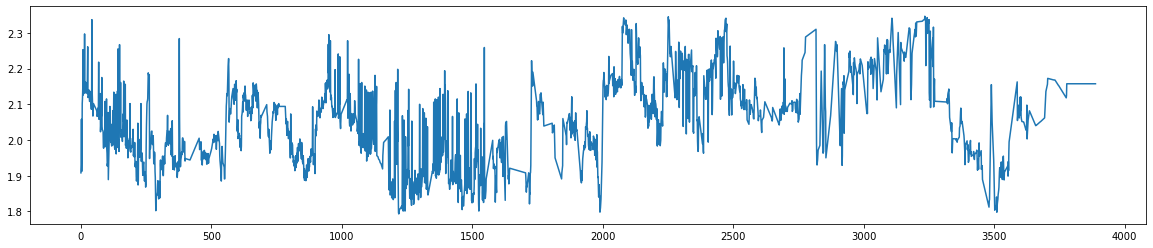

In [12]:
train_data[INDEX].plot(figsize=(20, 4))

<AxesSubplot:>

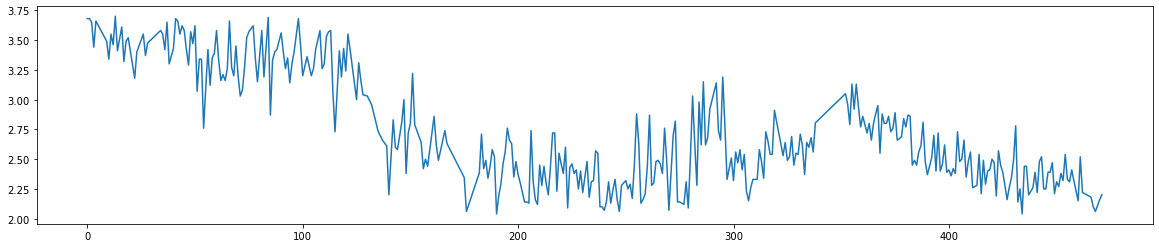

In [13]:
test_data[INDEX].plot(figsize=(20, 4))

In [15]:
test_data[100: 105]

,Time,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN
100,2020-06-11 16:00:00,29.3,8.89,23.800,367.90,8.1,1.92,0.011,0.032,3.20
101,2020-06-11 20:00:00,27.8,8.69,23.615,365.85,13.6,3.34,0.011,0.037,3.28
102,2020-06-12 00:00:00,27.2,8.85,23.430,363.80,13.8,2.78,0.011,0.042,3.36
103,2020-06-12 04:00:00,26.7,8.82,22.580,367.50,9.5,1.85,0.011,0.028,3.28
104,2020-06-12 08:00:00,26.8,8.75,20.550,370.30,9.2,1.89,0.011,0.026,3.20


## Deep Learning

In [19]:
class DataLoader(object):
    """ 
    Data PreProcess. 
    """
    def __init__(self, data, in_len, out_len, batch):
        self.in_len = in_len
        self.out_len = out_len
        self.batch = batch
        self.shape = data.shape
        self.raw_data = data.values

    def stdscale(self):
        self.scaler = StandardScaler().fit(self.raw_data.reshape(-1, 1))
        self.data = self.scaler.transform(self.raw_data.reshape(-1, 1))

    def minmaxscale(self):
        self.scaler = MinMaxScaler(feature_range=(0, 1)).fit(self.raw_data.reshape(-1, 1))
        self.data = self.scaler.transform(self.raw_data.reshape(-1, 1))

    def sliced(self):
        clips = [[] for i in range(2)]
        for i in range(self.shape[0] - (self.in_len+self.out_len) + 1):
            # print(i, self.in_size, self.in_size+self.out_size)
            clips[0].append([i, i+self.in_len])                            # input_clip
            clips[1].append([i+self.in_len, i+self.in_len+self.out_len])   # output_clip

        self.clips = clips


def init_dataset(data, in_size, out_size, batch):
    databox = DataLoader(data, in_size, out_size, batch)
    databox.minmaxscale()
    # databox.stdscale()
    databox.sliced()

    return databox

+ Feature Engineering

In [16]:
test_data

,Time,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN
0,2020-05-26 00:00:00,24.2,8.78,11.91,393.00,10.2,2.32,0.074,0.032,3.68
1,2020-05-26 04:00:00,24.2,8.67,11.77,400.20,7.6,2.05,0.074,0.030,3.68
2,2020-05-26 08:00:00,24.2,8.70,11.00,398.94,8.7,2.38,0.074,0.038,3.65
3,2020-05-26 12:00:00,24.2,8.73,11.69,397.68,8.3,1.97,0.072,0.034,3.44
4,2020-05-26 16:00:00,23.8,8.70,12.71,396.42,4.4,1.84,0.075,0.027,3.66
...,...,...,...,...,...,...,...,...,...,...
467,2020-08-11 20:00:00,31.3,9.05,19.78,285.58,7.0,3.10,0.011,0.036,2.10
468,2020-08-12 00:00:00,31.2,8.98,18.38,285.32,6.5,3.09,0.011,0.035,2.06
469,2020-08-12 04:00:00,31.1,8.93,15.97,285.06,6.3,3.17,0.011,0.036,2.11
470,2020-08-12 08:00:00,31.1,8.86,14.50,284.80,6.0,3.24,0.011,0.033,2.16


In [17]:
time_stp = test_data['Time'].map(datetime.timestamp)
time_stp

0      1.590422e+09
1      1.590437e+09
2      1.590451e+09
3      1.590466e+09
4      1.590480e+09
           ...     
467    1.597147e+09
468    1.597162e+09
469    1.597176e+09
470    1.597190e+09
471    1.597205e+09
Name: Time, Length: 472, dtype: float64

In [18]:
day = 24*60*60
year = (365.2425)*day

test_data['day_sin'] = np.sin(time_stp * (2*np.pi / day))
test_data['day_cos'] = np.cos(time_stp * (2*np.pi / day))
test_data['year_sin'] = np.sin(time_stp * (2*np.pi / year))
test_data['year_cos'] = np.cos(time_stp * (2*np.pi / year))

In [19]:
test_data

,Time,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN,day_sin,day_cos,year_sin,year_cos
0,2020-05-26 00:00:00,24.2,8.78,11.91,393.00,10.2,2.32,0.074,0.032,3.68,-8.660254e-01,-0.5,0.595487,-0.803365
1,2020-05-26 04:00:00,24.2,8.67,11.77,400.20,7.6,2.05,0.074,0.030,3.68,-8.660254e-01,0.5,0.593181,-0.805069
2,2020-05-26 08:00:00,24.2,8.70,11.00,398.94,8.7,2.38,0.074,0.038,3.65,-5.816058e-12,1.0,0.590871,-0.806766
3,2020-05-26 12:00:00,24.2,8.73,11.69,397.68,8.3,1.97,0.072,0.034,3.44,8.660254e-01,0.5,0.588555,-0.808457
4,2020-05-26 16:00:00,23.8,8.70,12.71,396.42,4.4,1.84,0.075,0.027,3.66,8.660254e-01,-0.5,0.586235,-0.810141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,2020-08-11 20:00:00,31.3,9.05,19.78,285.58,7.0,3.10,0.011,0.036,2.10,9.740772e-14,-1.0,-0.645042,-0.764147
468,2020-08-12 00:00:00,31.2,8.98,18.38,285.32,6.5,3.09,0.011,0.035,2.06,-8.660254e-01,-0.5,-0.647230,-0.762295
469,2020-08-12 04:00:00,31.1,8.93,15.97,285.06,6.3,3.17,0.011,0.036,2.11,-8.660254e-01,0.5,-0.649413,-0.760436
470,2020-08-12 08:00:00,31.1,8.86,14.50,284.80,6.0,3.24,0.011,0.033,2.16,-5.224096e-12,1.0,-0.651590,-0.758571


<AxesSubplot:>

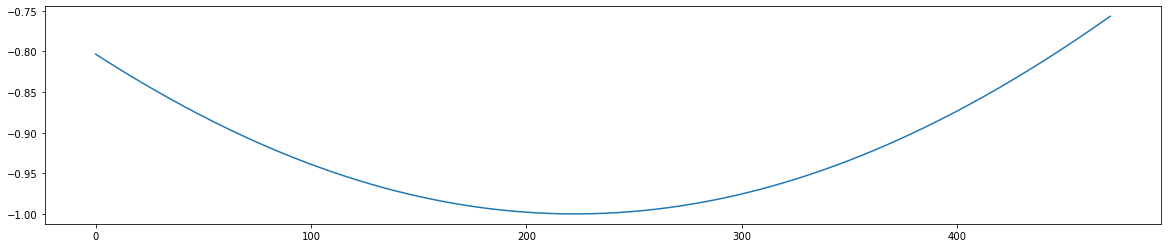

In [25]:
test_data['year_cos'].plot(figsize=(20, 4))

In [41]:
test_data = test_data.set_index('Time')
column_indices = {name: i for i, name in enumerate(test_data.columns)}

n = len(test_data)
train_df = test_data[0:int(n*0.7)]
val_df = test_data[int(n*0.7):int(n*0.9)]
test_df = test_data[int(n*0.9):]

num_features = test_data.shape[1]

In [42]:
column_indices

{'Temp': 0,
 'pH': 1,
 'DO': 2,
 'Elecon': 3,
 'Turbidity': 4,
 'CODMn': 5,
 'NH3N': 6,
 'TP': 7,
 'TN': 8,
 'day_sin': 9,
 'day_cos': 10,
 'year_sin': 11,
 'year_cos': 12}

In [43]:
val_df.shape

(94, 13)

+ Normalize the Data

In [44]:
train_df.sample(3)

,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN,day_sin,day_cos,year_sin,year_cos
Time,,,,,,,,,,,,,
2020-07-16 20:00:00,29.9,9.3825,26.49,288.25,9.0,4.65,0.023789,0.050,2.33,9.996005e-12,-1.0,-0.251089,-0.967964
2020-07-19 16:00:00,29.1,9.3000,24.90,285.10,7.9,4.92,0.028947,0.055,2.45,8.660254e-01,-0.5,-0.297952,-0.954581
2020-06-06 04:00:00,25.2,8.9000,15.15,392.60,3.2,1.98,0.037000,0.029,3.27,-8.660254e-01,0.5,0.431156,-0.902277


In [45]:
val_df.sample(3)

,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN,day_sin,day_cos,year_sin,year_cos
Time,,,,,,,,,,,,,
2020-07-21 12:00:00,28.335714,8.872143,19.556071,315.225,7.125,4.643929,0.032658,0.053357,2.8225,8.660254e-01,0.5,-0.327905,-0.944711
2020-07-24 04:00:00,27.800000,8.990000,12.780000,322.200,6.800,4.660000,0.032355,0.052000,3.1300,-8.660254e-01,0.5,-0.370883,-0.928680
2020-07-24 08:00:00,27.700000,8.890000,10.790000,329.500,6.600,4.420000,0.032140,0.048000,2.9200,4.151615e-13,1.0,-0.373544,-0.927613


In [46]:
test_df.sample(3)

,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN,day_sin,day_cos,year_sin,year_cos
Time,,,,,,,,,,,,,
2020-08-06 16:00:00,32.2,9.11,24.17,287.725,9.0,3.53,0.014944,0.040,2.44,8.660254e-01,-0.5,-0.574667,-0.818388
2020-08-05 20:00:00,32.2,9.08,22.68,287.500,7.5,3.24,0.016019,0.036,2.78,1.133672e-11,-1.0,-0.562876,-0.826541
2020-08-08 16:00:00,32.2,8.98,17.54,296.300,7.6,3.30,0.012364,0.038,2.47,8.660254e-01,-0.5,-0.602478,-0.798135


In [47]:
train_df.mean()

Temp         2.762667e+01
pH           8.994265e+00
DO           1.877236e+01
Elecon       3.457362e+02
Turbidity    8.432879e+00
CODMn        3.509402e+00
NH3N         3.668493e-02
TP           4.569773e-02
TN           2.843220e+00
day_sin     -4.952987e-14
day_cos     -9.419401e-15
year_sin     1.593614e-01
year_cos    -9.498395e-01
dtype: float64

In [48]:
train_df.std()

Temp          1.850171
pH            0.224893
DO            5.448070
Elecon       33.784972
Turbidity     3.464959
CODMn         1.325937
NH3N          0.022335
TP            0.015392
TN            0.500200
day_sin       0.708181
day_cos       0.708181
year_sin      0.263853
year_cos      0.054868
dtype: float64

In [49]:
train_df = (train_df - train_df.mean()) / train_df.std()
val_df = (val_df - train_df.mean()) / train_df.std()
test_df = (test_df - train_df.mean()) / train_df.std()

In [50]:
train_df

,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN,day_sin,day_cos,year_sin,year_cos
Time,,,,,,,,,,,,,
2020-05-26 00:00:00,-1.852081,-0.952743,-1.259594,1.398958,0.509998,-0.897027,1.670727,-0.889951,1.672892,-1.222888e+00,-0.706035,1.652910,2.669588
2020-05-26 04:00:00,-1.852081,-1.441865,-1.285291,1.612071,-0.240372,-1.100656,1.670727,-1.019892,1.672892,-1.222888e+00,0.706035,1.644171,2.638531
2020-05-26 08:00:00,-1.852081,-1.308468,-1.426626,1.574776,0.077092,-0.851776,1.670727,-0.500127,1.612916,-8.142737e-12,1.412069,1.635414,2.607594
2020-05-26 12:00:00,-1.852081,-1.175071,-1.299975,1.537481,-0.038349,-1.160991,1.581180,-0.760009,1.193083,1.222888e+00,0.706035,1.626638,2.576779
2020-05-26 16:00:00,-2.068278,-1.308468,-1.112753,1.500186,-1.163904,-1.259035,1.715500,-1.214804,1.632908,1.222888e+00,-0.706035,1.617844,2.546084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-19 04:00:00,0.796323,0.692484,-0.022459,-1.803649,-0.240372,0.913013,-0.395924,0.734316,-0.706157,-1.222888e+00,0.706035,-1.702052,-0.132478
2020-07-19 08:00:00,0.526078,0.425691,-0.070182,-1.735572,-0.355813,0.468045,-0.379429,0.279522,-0.646181,-9.144682e-12,1.412069,-1.712448,-0.117266
2020-07-19 12:00:00,0.634176,1.137141,0.579590,-1.812529,-0.182651,0.822511,-0.362933,0.864258,-0.306317,1.222888e+00,0.706035,-1.722834,-0.101912


+ DataWindow

In [66]:
class WindowGenerator():
    """
    Data Window Generator.
    """
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_cols=None):
        # data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        # label
        self.label_cols = label_cols
        if label_cols is not None:
            self.label_col_indices = {col:i for i, col in enumerate(label_cols)}
        self.col_indices = {col: i for i, col in enumerate(train_df.columns)}
        # Window parmas
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_width = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_width)[self.input_slice]
        
        self.label_start = self.total_width - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_width)[self.label_slice]
        
    def __repr__(self):
        '''
        Self Information.
        '''
        return '\n\n'.join([
            f'Total Width:   {self.total_width}',
            f'Input Indices: {self.input_indices}',
            f'Label Indices: {self.label_indices}',
            f'Label Column Names: {self.label_cols}'
        ])
    
    def split_window(self, features):
        '''
        Features & Labels Split.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        if self.label_cols is not None:
            labels = tf.stack([labels[:, :, self.col_indices[col]] for col in self.label_cols], axis=-1)
            
        # -> tf.data.Dataset
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def make_dataset(self, data):
        '''
        Transform to tf.data.Dataset.
        '''
        data = np.array(data, dtype=np.float32)
        dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            tartgets=None,
            sequence_length=self.total_width,
            sequence_stride=1,
            shuffle=True,
            batch=BATCH,
        )
        dataset = dataset.map(self.split_window)
        
        return dataset
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        '''
        Get Batch Inputs&Labels Example.
        '''
        result = getattr(self, '_example', None)
        if result is not None:
            # # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
            
        return result

In [67]:
win = WindowGenerator(
    input_width=48, label_width=48, shift=48, train_df=train_df, val_df=val_df, test_df=test_df, label_cols=[INDEX])
win

Total Width:   96

Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]

Label Indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]

Label Column Names: ['TN']

+ Train

In [2]:
MAX_EPOCHS=20
def compile_fit(model, window, petience=2):
    """
    Complie & Fit
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode="min")
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizer.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping])
    
    return history

### Single-shot models

In [ ]:
# CNN Model
CONV_WIDTH=6
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

---
## Old

In [20]:
train_set = init_dataset(train_data[INDEX], SEQ_IN, SEQ_OUT, BATCH)
valid_set = init_dataset(valid_data[INDEX], SEQ_IN, SEQ_OUT, BATCH)
test_set = init_dataset(test_data[INDEX], SEQ_IN, SEQ_OUT, BATCH)

In [21]:
train_set.shape

(3889,)

In [14]:
def resize(data):
    # clips
    clips_X = data.clips[0]
    clips_y = data.clips[1]
    # values
    X = [data.data[clip[0]:clip[1]] for clip in clips_X]
    y = [data.data[clip[0]:clip[1]] for clip in clips_y]    
    X = np.array(X)
    y = np.array(y)
    print("Raw X, y shape: {0} {1}".format(X.shape, y.shape))
    X = X.reshape((X.shape[0], -1))
    y = y.reshape((y.shape[0], -1))
    # reshape
    if X.shape[0] % data.batch == 0:
        X = X.reshape((-1, data.batch, X.shape[-1]))
    else:
        X = X[:-(X.shape[0]%data.batch)].reshape((-1, data.batch, X.shape[-1]))
    if y.shape[0] % data.batch == 0:
        y = y.reshape((-1, data.batch, y.shape[-1]))
    else:
        y = y[:-(y.shape[0]%data.batch)].reshape((-1, data.batch, y.shape[-1]))
    print("New X, y shape: {0} {1}".format(X.shape, y.shape))

    return torch.from_numpy(X).float(), torch.from_numpy(y).float()

In [15]:
train_X, train_y = resize(train_set)

Raw X, y shape: (3882, 5, 1) (3882, 3, 1)
New X, y shape: (242, 16, 5) (242, 16, 3)


In [16]:
valid_X, valid_y = resize(valid_set)

Raw X, y shape: (465, 5, 1) (465, 3, 1)
New X, y shape: (29, 16, 5) (29, 16, 3)


In [17]:
test_X, test_y = resize(test_set)

Raw X, y shape: (465, 5, 1) (465, 3, 1)
New X, y shape: (29, 16, 5) (29, 16, 3)


In [18]:
class LSTMModel(nn.Module):
    """ LSTM """
    def __init__(self, batch, in_size, feature_dev, hidden_size, out_size, num_layers):
        super(LSTMModel, self).__init__()
        self.batch = batch
        self.in_size = in_size
        self.feature_dev = feature_dev
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.num_layers = num_layers

        self.layer1 = nn.LSTM(in_size*feature_dev, 
                              hidden_size, 
                              num_layers)
        self.hidden_state = self.init_hidden_state()
        self.layer2 = nn.Linear(hidden_size, 
                                out_size*feature_dev)

    def init_hidden_state(self):
        return (Variable(torch.zeros(self.num_layers, self.batch, self.hidden_size)),
                Variable(torch.zeros(self.num_layers, self.batch, self.hidden_size)))

    def forward(self, inputs):
        self.out1, self.hidden_state = self.layer1(inputs, self.hidden_state)
        self.out1 = self.out1.view(-1, self.batch, self.hidden_size)
        self.out2 = self.layer2(self.out1)

        return self.out2

In [19]:
class NNetAR(nn.Module):
    '''
    Full Connect Network.
    '''
    def __init__(self, in_size, hidden_size, drop_rate, out_size):
        super(FCNNet, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.drop_rate = drop_rate
        self.out_size = out_size

        self.layer1 = nn.Linear(self.in_size, self.hidden_size)
        self.layer2 = nn.ReLU()
        self.layer3 = nn.Dropout(self.drop_rate)
        self.layer4 = nn.Linear(self.hidden_size, self.out_size)

    def forward(self, X):
        assert X.shape[-1] == self.in_size
        
        out1 = self.layer1(X)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        pred_y = self.layer4(out3)

        return pred_y

In [22]:
def train(model, train_data, valid_data, optimizer, criterion, model_saver, epochs):
    # loss recorder
    train_records = [[] for i in range(2)]
    valid_records = []
    (train_X, train_y) = train_data
    (valid_X, valid_y) = valid_data
    # early stopping
    no_better = 0
    for epoch in range(1, epochs+1):
        # forward
        optimizer.zero_grad()
        # print(train_X.size(), train_y.size())
        outputs = model.forward(train_X)
        loss = criterion(outputs, train_y)
        # backward
        with torch.autograd.set_detect_anomaly(True):
            loss.backward(retain_graph=True)
        # update 
        optimizer.step()

        if epoch % 50 == 0:
            # validation
            val_outputs = model.forward(valid_X)
            val_loss = criterion(val_outputs, valid_y)
            print("Epoch: {0:d}\tTrain Loss: {1:.7f}\tValid Loss: {2:.7f}".format(epoch, 
                                                                                  loss,
                                                                                  val_loss))
            if len(valid_records)==0 or val_loss<=min(valid_records):
                torch.save(model, model_saver)
            else:
                no_better += 1
            train_records[0].append(epoch)
            train_records[1].append(loss)
            valid_records.append(val_loss)

        # Add early stopping
        '''
        if no_better > 10:
            print('Overfitting, Early stopping!')
            break
        else:
            continue
        '''

    # Plot training curve
    plt.plot(train_records[0], train_records[1], 'g', label='Train_Err')
    plt.plot(train_records[0], valid_records, 'b', label='Valid_Err')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.title('Loss vs. Epoch')
    plt.savefig('train.png')

In [23]:
if MODE == 'LSTM':
    model = LSTMModel(
        batch=BATCH, in_size=SEQ_IN, feature_dev=1, hidden_size=32, out_size=SEQ_OUT, num_layers=3)
    train_data = (train_X, train_y)
    valid_data = (valid_X, valid_y) 
elif MODE == 'FCN':
    model = FCNNet(in_size=SEQ_IN, hidden_size=256, drop_rate=0.2, out_size=SEQ_OUT)
    train_data = (train_X.view(-1, train_X.size()[-1]), 
                    train_y.view(-1, train_y.size()[-1]))
    valid_data = (valid_X.view(-1, valid_X.size()[-1]), 
                    valid_y.view(-1, valid_y.size()[-1]))

print(train_data[0].shape)
print(train_data[1].shape)
# ---------------------------------------
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
print("{0} Net Start training ...".format(MODE))
train(model,
    train_data,valid_data,
    optimizer,
    criterion,
    '../model/FCN.pkl',
    1000)

torch.Size([242, 16, 5])
torch.Size([242, 16, 3])
LSTM Net Start training ...


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [32, 128]], which is output 0 of TBackward, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [50]:
m = torch.load('../model/FCN.pkl')
m.layer3

Dropout(p=0.2, inplace=False)

In [62]:
test_data.head(18)

,Time,Temp,pH,DO,Elecon,Turbidity,CODMn,NH3N,TP,TN
0,2020-05-26 00:00:00,24.200,8.780,11.910,393.000000,10.20,2.320000,0.0740,0.0320,3.680
1,2020-05-26 04:00:00,24.200,8.670,11.770,400.200000,7.60,2.050000,0.0740,0.0300,3.680
2,2020-05-26 08:00:00,24.200,8.700,11.000,398.940000,8.70,2.380000,0.0740,0.0380,3.650
3,2020-05-26 12:00:00,24.200,8.730,11.690,397.680000,8.30,1.970000,0.0720,0.0340,3.440
4,2020-05-26 16:00:00,23.800,8.700,12.710,396.420000,4.40,1.840000,0.0750,0.0270,3.660
5,2020-05-26 20:00:00,24.280,8.718,13.986,396.168000,4.66,1.864000,0.0742,0.0284,3.626
6,2020-05-27 00:00:00,24.760,8.736,15.262,395.916000,4.92,1.888000,0.0734,0.0298,3.592
7,2020-05-27 04:00:00,25.240,8.754,16.538,395.664000,5.18,1.912000,0.0726,0.0312,3.558
8,2020-05-27 08:00:00,25.720,8.772,17.814,395.412000,5.44,1.936000,0.0718,0.0326,3.524
9,2020-05-27 12:00:00,26.200,8.790,19.090,395.160000,5.70,1.960000,0.0710,0.0340,3.490


In [80]:
mmscale = MinMaxScaler().fit(test_data['TN'][:12].values.reshape(-1, 1))
tt = torch.from_numpy(mmscale.transform(test_data['TN'][:12].values.reshape(-1, 1)).reshape(-1, SEQ_IN)).float()
tt

tensor([[1.0000, 1.0000, 0.9118, 0.2941, 0.9412, 0.8412, 0.7412, 0.6412, 0.5412,
         0.4412, 0.0000, 0.6176]])

In [85]:
mmscale.inverse_transform(m.forward(tt).detach().numpy())

array([[3.5538964, 3.563002 , 3.5127678, 3.5921254, 3.545763 , 3.635523 ]],
      dtype=float32)

In [86]:
test_data.head(18)['TN'].values[12:]

array([3.46, 3.7 , 3.41, 3.51, 3.61, 3.32])